In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
import shutil
from glob import glob
from PIL import Image
import numpy as np
from early_stopping_pytorch import EarlyStopping
from sklearn.model_selection import train_test_split

torch.manual_seed(42)


os.chdir("c:/Users/Fuglsang/OneDrive/DS projects/cat-dog-image-classifier/")
print("cwd:", os.getcwd())

cwd: c:\Users\Fuglsang\OneDrive\DS projects\cat-dog-image-classifier


In [4]:
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


12.6
True
1
NVIDIA GeForce RTX 4060 Ti


In [75]:
# do the train/val/test split

raw_folder = "data/raw"
destination_folder = "data/data_split"

for clss in ("Cat", "Dog"):
    all_files = glob(os.path.join(raw_folder, clss, "*.jpg"))
    print(all_files)
    
    # create a train/val/test split of 0.8, 0.10, 0.10
    train_files, remainder = train_test_split(all_files, test_size=(0.2), random_state = 42)
    val_files, test_files = train_test_split(remainder, test_size=0.5, random_state=42)
    
    for split_name, file_list in zip(("train", "val", "test"), (train_files, val_files, test_files)):
        out_folder = os.path.join(destination_folder, split_name, clss)
        os.makedirs(out_folder, exist_ok=True)
        for src_path in file_list:
            shutil.copy(src_path, out_folder)

print("Done creating train/val/test in", destination_folder)

['data/raw\\Cat\\0.jpg', 'data/raw\\Cat\\1.jpg', 'data/raw\\Cat\\10.jpg', 'data/raw\\Cat\\100.jpg', 'data/raw\\Cat\\1000.jpg', 'data/raw\\Cat\\10000.jpg', 'data/raw\\Cat\\10001.jpg', 'data/raw\\Cat\\10002.jpg', 'data/raw\\Cat\\10003.jpg', 'data/raw\\Cat\\10004.jpg', 'data/raw\\Cat\\10005.jpg', 'data/raw\\Cat\\10006.jpg', 'data/raw\\Cat\\10007.jpg', 'data/raw\\Cat\\10008.jpg', 'data/raw\\Cat\\10009.jpg', 'data/raw\\Cat\\1001.jpg', 'data/raw\\Cat\\10010.jpg', 'data/raw\\Cat\\10011.jpg', 'data/raw\\Cat\\10012.jpg', 'data/raw\\Cat\\10013.jpg', 'data/raw\\Cat\\10014.jpg', 'data/raw\\Cat\\10015.jpg', 'data/raw\\Cat\\10016.jpg', 'data/raw\\Cat\\10017.jpg', 'data/raw\\Cat\\10018.jpg', 'data/raw\\Cat\\10019.jpg', 'data/raw\\Cat\\1002.jpg', 'data/raw\\Cat\\10020.jpg', 'data/raw\\Cat\\10021.jpg', 'data/raw\\Cat\\10022.jpg', 'data/raw\\Cat\\10023.jpg', 'data/raw\\Cat\\10024.jpg', 'data/raw\\Cat\\10025.jpg', 'data/raw\\Cat\\10026.jpg', 'data/raw\\Cat\\10027.jpg', 'data/raw\\Cat\\10028.jpg', 'data/r

In [93]:
# I computed the normalization values for each dataset, and took the avg. mean and std values.

transform=v2.Compose([
    #v2.RandomResizedCrop(size=(144, 144), antialias=True),
    v2.Resize((144, 144)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.4892, 0.4556, 0.4175], [0.2221, 0.2166, 0.2170])
    ])


transform_test_val=v2.Compose([
    v2.Resize((144, 144)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.4892, 0.4556, 0.4175], [0.2221, 0.2166, 0.2170])
    ])

In [94]:
# load ImageFolder, and apply transformations
trainset = ImageFolder("data/data_split/train", transform=transform)
testset = ImageFolder("data/data_split/test", transform=transform_test_val)
valset = ImageFolder("data/data_split/val", transform=transform_test_val)


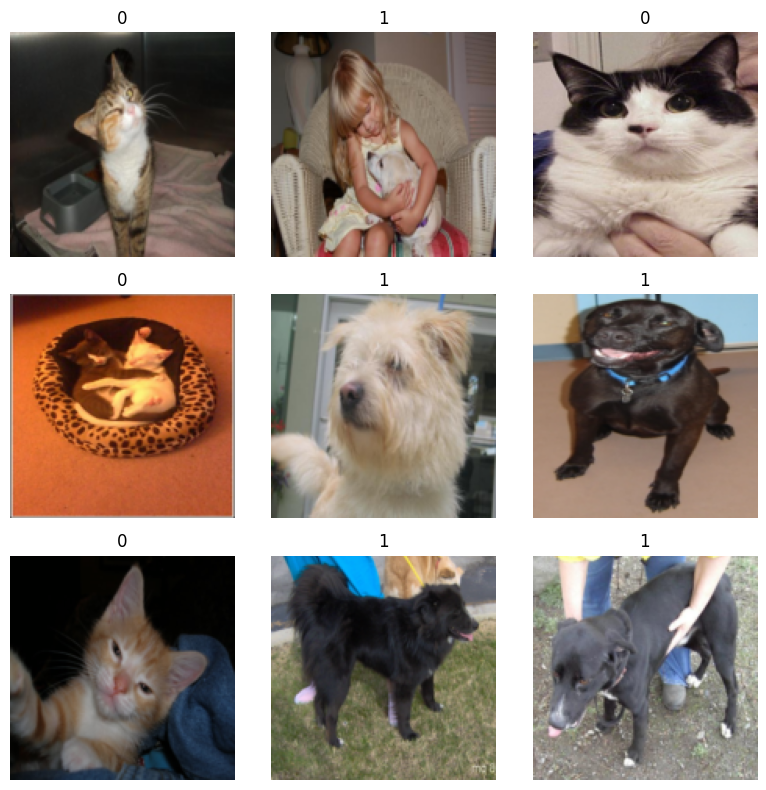

In [95]:
# Denormalize for plotting
mean = torch.tensor([0.4892, 0.4556, 0.4175])
std  = torch.tensor([0.2221, 0.2166, 0.2170])

def show(img_tensor, ax):
    # undo normalization
    img = img_tensor * std[:,None,None] + mean[:,None,None]
    img = img.permute(1,2,0).clamp(0,1)
    ax.imshow(img)
    ax.axis("off")

fig, axes = plt.subplots(3,3, figsize=(8,8))
for ax in axes.flatten():
    idx = torch.randint(len(trainset), (1,)).item()
    img, lbl = trainset[idx]
    show(img, ax)
    ax.set_title(lbl)
plt.tight_layout()
plt.show()


In [ ]:
batch_size = 128

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
validation_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)

In [83]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cuda device


In [ ]:
import torch.nn as nn

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(32)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)

        
        
        self.flatten = nn.Flatten()
        self.fc1 = None
        self.dropout = nn.Dropout(.50)
        self.fc2 = None

        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool2(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool3(x)
        
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.maxpool4(x)
        
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.maxpool5(x)

        x = self.flatten(x)
        

        # when experimenting i had to constantly change the input features in the fcn. I found this workaround.
        if self.fc1 is None:
            in_features = x.shape[1]
            self.fc1 = nn.Linear(in_features, 128).to(x.device)
            self.fc2 = nn.Linear(128, 2).to(x.device)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 32, k

In [97]:
def train(dataloader, model, criterion, optimizer):
    dataset_size = len(dataloader.dataset)
    train_loss, correct = 0,0
    
    for batch, (X, y), in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        
        optimizer.zero_grad()
        
        #compute prediction error
        pred = model(X)
        loss = criterion(pred, y)
        
        # ToDo: add reguarization step
        
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # loss for each epoch
        train_loss += loss.item()
        
        # calculate number of correct for this batch
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        #print progeress every 100 batches
        if batch % 4 ==0:
            loss, current = loss.item(), (batch+1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{dataset_size:>5d}]")
    
    # calculate avg loss (loss divided by number of batches)
    train_loss /= len(dataloader)
    
    # convert correct predictions into test_accuracy
    train_accuracy = correct / dataset_size
    
    return train_loss, train_accuracy

In [98]:
def test(dataloader, model, loss_fn):
    total_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            # accumulate loss for each epoch
            test_loss += loss_fn(pred, y).item()
            
            # calculate number of correct predictions in this batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    # calculate avg test_loss
    test_loss /= num_batches
    
    # convert correct predictions into test_accuracy
    test_accuracy = correct / total_samples
    
    
    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_accuracy

In [99]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
early_stopping = EarlyStopping(patience=5, verbose=True)

In [100]:
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

    
epochs = 40
for epoch in range(epochs):

    print(f"Epoch {epoch+1}\n-------------------------------")
    
    # Training phase
    train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation
    val_loss, val_accuracy = test(validation_dataloader, model, loss_fn)
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)
    
    print(f"Training Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, val Loss: {val_loss:.4f}, val Accuracy: {val_accuracy:.2%}")
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
print("Done!")
    


Epoch 1
-------------------------------
loss: 0.696568  [  256/19998]
loss: 0.649913  [ 1280/19998]
loss: 0.652133  [ 2304/19998]
loss: 0.671443  [ 3328/19998]
loss: 0.642024  [ 4352/19998]
loss: 0.626257  [ 5376/19998]
loss: 0.647694  [ 6400/19998]
loss: 0.660062  [ 7424/19998]
loss: 0.602254  [ 8448/19998]
loss: 0.650032  [ 9472/19998]
loss: 0.580529  [10496/19998]
loss: 0.613497  [11520/19998]
loss: 0.589110  [12544/19998]
loss: 0.618552  [13568/19998]
loss: 0.643580  [14592/19998]
loss: 0.584308  [15616/19998]
loss: 0.558691  [16640/19998]
loss: 0.572262  [17664/19998]
loss: 0.597926  [18688/19998]
loss: 0.584528  [19712/19998]
Test Error: 
 Accuracy: 74.2%, Avg loss: 0.587613 

Training Loss: 0.6151, Train Accuracy: 66.70%, val Loss: 0.5876, val Accuracy: 74.16%
Validation loss decreased (inf --> 0.587613).  Saving model ...
Epoch 2
-------------------------------
loss: 0.577707  [  256/19998]
loss: 0.632884  [ 1280/19998]
loss: 0.620870  [ 2304/19998]
loss: 0.564773  [ 3328/19998

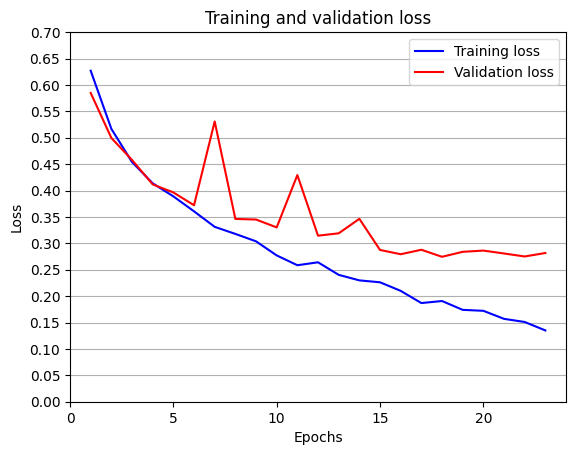

In [92]:
#plots the loss curves

epochs_plot = range(1, len(train_loss_values)+1)
plt.plot(epochs_plot, train_loss_values, 'b', label='Training loss')
plt.plot(epochs_plot, val_loss_values, 'r', label='Validation loss')
plt.ylim(0, 0.7)
plt.yticks(np.arange(0, 0.75, 0.05))
plt.grid(axis='y')
plt.xlim(0, len(train_loss_values)+1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

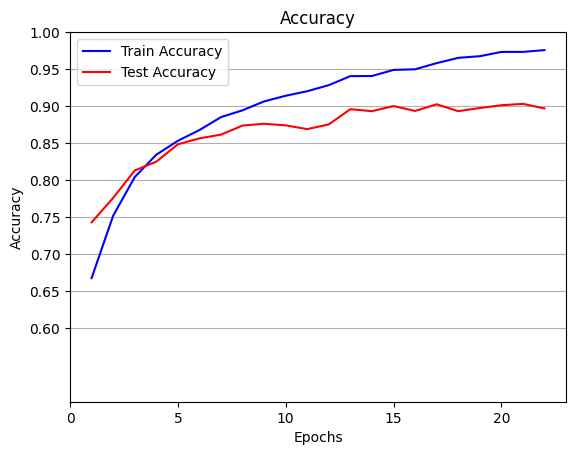

In [69]:
# plots the accuracy curves
epochs_plot = range(1, len(train_loss_values)+1)
plt.plot(epochs_plot, train_accuracy_values, 'b', label='Train Accuracy')
plt.plot(epochs_plot, val_accuracy_values, 'r', label='Test Accuracy')
plt.ylim(0.5, 1)
plt.yticks(np.arange(0.6, 1.05, 0.05))
plt.grid(axis='y')
plt.xlim(0, len(train_loss_values)+1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
plt.show()

In [73]:
# Saving the model
PATH = 'data/saved_models/cat_dog_cnn_1.pth'
torch.save(model.state_dict(), PATH)

In [70]:
total, correct = 0, 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 89.14666666666666 %


In [71]:
classes = ("cat", "dog")

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: cat is 93.2 %
Accuracy for class: dog is 85.1 %
